In [1]:
from scipy.io import mmread
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymn
import os
import scipy
os.chdir('../')
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 4, 4
import pickle

In [2]:
def filter_genes(genes):
    gener=[]
    for gene in genes:
        if gene not in  neu.var_names:
            gener.append(gene)
    genes = list(set(genes)-set(gener))
    dff = sc.get.obs_df(neu, keys=[*genes,'clusters'],layer = 'counts')
    hgenes = []
    for gene in genes:
        df = dff[[gene,'clusters']].copy()
        df1 = df[df[gene]>0]
        p = df1.groupby("clusters").count()/df.groupby("clusters").count()
        if p[gene].max() > 0.3:
            hgenes.append(gene)
    return hgenes

In [3]:
neu = sc.read_h5ad('cn_neurons.h5ad')

In [4]:
go_mtx = mmread('go_mouse.mtx')
go_genes = np.genfromtxt('go_mouse_row_labels.txt', dtype=str)
go_barcodes = np.genfromtxt('go_mouse_col_labels.txt',
                            dtype=str,
                            delimiter='\n')
go_sets = pd.DataFrame(go_mtx.todense(), index=go_genes, columns=go_barcodes)

In [5]:
known_genes = neu.var_names
shared_genes = np.intersect1d(known_genes, go_sets.index)
go_sets = go_sets.loc[shared_genes]
min_size = 10
max_size = 100
set_sizes = go_sets.sum()
go_sets = go_sets.loc[:, (set_sizes > min_size) & (set_sizes < max_size)]

In [6]:
import mkl; mkl.set_num_threads(64)

64

In [7]:
%%time
neu.obs.columns = neu.obs.columns.astype(str)
neu.obs['sample'] = neu.obs['sample'].astype(str)
neu.obs['clusters'] = neu.obs['clusters'].astype(str)
pymn.MetaNeighbor(adata=neu,
                  study_col='sample',
                  ct_col='clusters',
                  genesets=go_sets,
                  fast_version=True,
                  fast_hi_mem=True)
neu.uns['go_sets_MetaNeighbor'] = neu.uns['MetaNeighbor'].copy()
neu.uns['go_sets_MetaNeighbor_params'] =neu.uns['MetaNeighbor_params'].copy()
del neu.uns['MetaNeighbor']
del neu.uns['MetaNeighbor_params']

CPU times: user 5h 49min 34s, sys: 21h 30min 13s, total: 1d 3h 19min 47s
Wall time: 28min 12s


In [8]:
neu.uns['go_sets_MetaNeighbor'].to_csv('go_sets_MetaNeighbor.csv')

In [9]:
df = neu.uns['go_sets_MetaNeighbor'].T
df['AUROC'] = df.mean(axis = 1)
df =df.sort_values(by = 'AUROC', ascending=False)
df = df[['AUROC']]
for f in df.index:
    genes = list(go_sets[go_sets[f]==1].index)   
    df.loc[f, 'Gene Counts'] = len(genes)
    strs =''
    for gene in genes:
        strs = strs + gene + ', '
    df.loc[f, 'Genes'] =strs
df['Gene Counts'] = df['Gene Counts'].astype(int)

In [10]:
df.to_csv('GO_AUROC.csv')

In [11]:
hgnc = pd.read_csv('HGNC_Gene_Group.csv')
genes = list(set(list(map(lambda x: x[0].upper() + x[1:].lower(), list(set(hgnc['Approved symbol']))))))
group = []
for i in range(len(hgnc)):
    group.append(hgnc.iloc[i]['Group name']+':'+str(hgnc.iloc[i]['Group ID']))
group=list(set(group))

hgnc_sets = pd.DataFrame(index =genes, columns =group )
for gene in genes:
    dff = hgnc[hgnc['Approved symbol']==gene.upper()].copy()
    for i in dff.index:
        c = dff.loc[i]['Group name'] +':' +str(dff.loc[i]['Group ID'])
        #print(c)
        hgnc_sets.loc[gene,c]= 1
hgnc_sets= hgnc_sets.fillna(0)

In [18]:
import mkl; mkl.set_num_threads(64)

64

In [19]:
%%time
neu.obs.columns = neu.obs.columns.astype(str)
neu.obs['sample'] = neu.obs['sample'].astype(str)
neu.obs['clusters'] = neu.obs['clusters'].astype(str)
pymn.MetaNeighbor(adata=neu,
                  study_col='sample',
                  ct_col='clusters',
                  genesets=hgnc_sets,
                  fast_version=True,
                  fast_hi_mem=True)
neu.uns['hgnc_sets_MetaNeighbor'] = neu.uns['MetaNeighbor'].copy()
neu.uns['hgnc_sets_MetaNeighbor_params'] =neu.uns['MetaNeighbor_params'].copy()
del neu.uns['MetaNeighbor']
del neu.uns['MetaNeighbor_params']

CPU times: user 33min 56s, sys: 2h 9min 40s, total: 2h 43min 36s
Wall time: 2min 55s


In [20]:
neu.uns['hgnc_sets_MetaNeighbor'].to_csv('hgnc_sets_MetaNeighbor.csv')

In [21]:
df = neu.uns['hgnc_sets_MetaNeighbor'].T
df['AUROC'] = df.mean(axis = 1)
df =df.sort_values(by = 'AUROC', ascending=False)
df = df[['AUROC']]
for f in df.index:
    genes = list(hgnc_sets[hgnc_sets[f]==1].index)   
    df.loc[f, 'Gene Counts'] = len(genes)
    strs =''
    for gene in genes:
        strs = strs + gene + ', '
    df.loc[f, 'Genes'] =strs
df['Gene Counts'] = df['Gene Counts'].astype(int)
df.to_csv('HGNC_AUROC.csv')

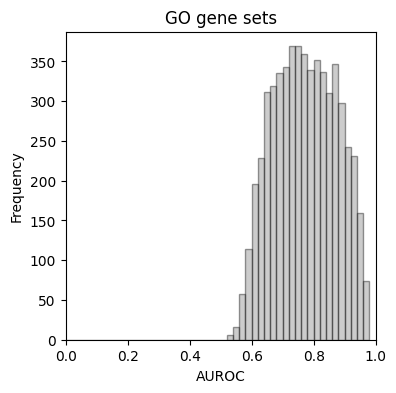

In [31]:
df = pd.read_csv('go_sets_MetaNeighbor.csv',index_col=0).T

df['mean'] = df.mean(axis=1)
for i in df.index:
    if (('synaptic' in  i) or ('synapse' in i)):
        df.loc[i, 'geneset'] = 'synaptic'
    if 'cell adhesion' in  i:
        df.loc[i, 'geneset'] = 'cell adhesion'
    if 'channel' in  i:
        df.loc[i, 'geneset'] = 'ion channel'
        
rcParams['figure.figsize'] = 4, 4
sns.distplot(df['mean'], hist=True, kde=False, 
             bins=np.arange(0,1,0.02), color = 'gray',
             hist_kws={'edgecolor':'black'})
plt.title('GO gene sets')
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.xlim([0,1])
plt.savefig('GO.pdf',dpi=300)

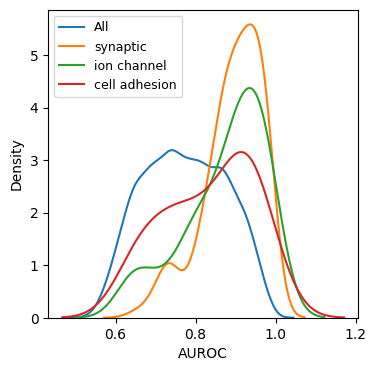

In [32]:
sns.distplot(df['mean'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
                 label = 'All'
            )
sns.distplot(df[df['geneset']=='synaptic']['mean'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
            label = 'synaptic'
            )
sns.distplot(df[df['geneset']=='ion channel']['mean'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
            label = 'ion channel'
            )
sns.distplot(df[df['geneset']=='cell adhesion']['mean'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
            label = 'cell adhesion'
            )
plt.legend(prop={'size': 9})
plt.xlabel('AUROC')
plt.ylabel('Density')
plt.savefig('GO_density.pdf',dpi=300)

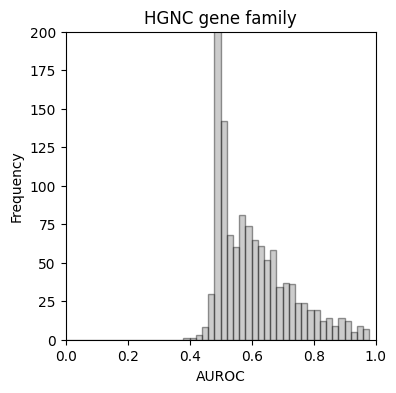

In [34]:
df = pd.read_csv('hgnc_sets_MetaNeighbor.csv',index_col=0)
df = df.T
df['mean'] = df.mean(axis=1)

rcParams['figure.figsize'] = 4, 4
sns.distplot(df['mean'], hist=True, kde=False, 
             bins=np.arange(0,1,0.02), color = 'gray',
             hist_kws={'edgecolor':'black'})
plt.title('HGNC gene family')
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.ylim([0,200])
plt.xlim([0,1])
plt.savefig('HGNC.pdf',dpi=300)

In [41]:
df[df['mean']>=0.8][['mean']].to_csv('hgnc_auroc0.8.csv')

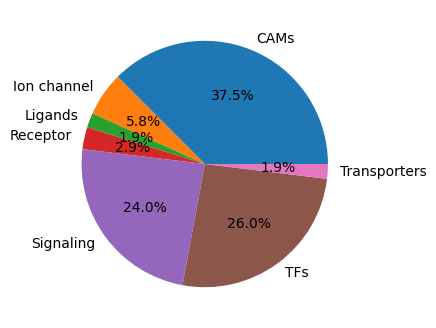

In [52]:
df8=pd.read_csv('hgnc_auroc0.8.csv')
df = pd.DataFrame( df8.groupby('Cat')['Cat'].count()/len(df8))
import matplotlib.pyplot as plt
plt.pie(df['Cat'], labels=df.index,
        autopct='%1.1f%%')
#plt.show()
plt.savefig('HGNC_pie.pdf',dpi=300)
